In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd
import geopandas as gpd
from src.settings import *
from tqdm.auto import tqdm
# import torch
# import pytorch_lightning as pl
# from torch.utils.data.dataloader import DataLoader
# from torch.utils.data.dataset import Dataset
# from pytorch_lightning.loggers import WandbLogger
# import wandb
# from src.models.autoencoder import LitAutoEncoder, LitVAE
import json5 as json
import pickle as pkl
from src.tools.configs import ExperimentConfig, DatasetGenerationConfig
from src.tools.feature_extraction import SpatialDataset
import dataclasses
import gzip
from src.tools.feature_extraction import apply_feature_selection, normalize_df, apply_features_mapping, apply_features_assume
import xgboost as xgb
from IPython.display import display
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import gzip

tqdm.pandas()

In [3]:
ec = ExperimentConfig(
    # dataset_filename="dataset_2021-12-19_02-25-14_poland.pkl.gz",
    dataset_filename="dataset_2021-12-19_02-40-36_all.pkl.gz",
    model_name="autoencoder",
    mode="edges",
    test_cities=["Łódź"],
    random_seed=42,
    batch_size=64,
    num_workers=3,
    shuffle=True,
    hidden_dim=64,
    enc_out_dim=40,
    latent_dim=30,
    epochs=10,
    kl_coeff=0.1,
    lr=1e-3
)

In [4]:
ds_path = FEATURES_DIR / ec.dataset_filename
with gzip.open(ds_path, "rb") as f:
    ds: SpatialDataset = pkl.load(f)

ds.__annotations__

{'config': src.tools.configs.DatasetGenerationConfig,
 'cities': pandas.core.frame.DataFrame,
 'edges': geopandas.geodataframe.GeoDataFrame,
 'edges_feature_selected': geopandas.geodataframe.GeoDataFrame,
 'hexagons': geopandas.geodataframe.GeoDataFrame,
 'hex_agg': typing.Optional[pandas.core.frame.DataFrame],
 'hex_agg_normalized': typing.Optional[pandas.core.frame.DataFrame]}

In [5]:
ds_config = ds.config
cities = ds.cities
edges = ds.edges
hexagons = ds.hexagons
hex_agg = ds.hex_agg
hex_agg_normalized = ds.hex_agg_normalized

In [6]:
random_seed = ec.random_seed

In [7]:
data = apply_feature_selection(edges, ds_config.featureset_selection)
data = apply_features_mapping(data, [{
    "feature": "highway",
    "mapping": {
        "motorway_link": "motorway",
        "primary_link": "primary",
        "secondary_link": "secondary",
        "tertiary_link": "tertiary",
        "trunk_link": "trunk"
    }
}])
# data = apply_features_mapping(data, [{
#     "feature": "surface",
#     "mapping": {
#         "asphalt": "paved",
#         "paving_stones": "paved",
#         "concrete": "paved",
#         "concrete_prefabricated": "paved",
#         "compacted": "unpaved",
#         "ground": "unpaved"
#     }
# }])
data = apply_features_assume(data, {
      "surface": "paved",
})
# data = apply_features_mapping(data, [{
#     "feature": "highway",
#     "mapping": {
#         'secondary': 'not_residential', 
#         'tertiary': 'not_residential', 
#         'living_street': 'not_residential', 
#         'primary': 'not_residential', 
#         'unclassified': 'not_residential', 
#         'motorway': 'not_residential', 
#         'trunk': 'not_residential'
#     }
# }])
# data = data.drop(columns="highway_residential")
# data = data.drop(columns="surface_paved")
data

oneway_True  lanes_1  \
continent country    city       h3_id                                   
Asia      Kazakhstan Nur-Sultan 89215382263ffff            1        0   
                                89215382263ffff            1        0   
                                8921538227bffff            1        0   
                                89215382273ffff            1        0   
                                89215382263ffff            1        0   
...                                                      ...      ...   
Oceania   Australia  Sydney     89be0845cc7ffff            0        0   
                                89be0845c8bffff            0        0   
                                89be0845c83ffff            0        0   
                                89be0844223ffff            1        0   
                                89be0844233ffff            1        0   

                                                 lanes_2  lanes_3  lanes_4  \
continent country    city       h3_id                                        
Asia      Kazakhstan Nur-Sultan 89215382263ffff        1        0        0   
                                89215382263ffff        0        0        0   
                                8921538227bffff        0        0        0   
                                89215382273ffff        0        0        0   
                                89215382263ffff        1        0        0   
...                                                  ...      ...      ...   
Oceania   Australia  Sydney     89be0845cc7ffff        0        0        0   
                                89be0845c8bffff        0        0        0   
                                89be0845c83ffff        0        0        0   
                                89be0844223ffff        0        0        0   
                                89be0844233ffff        0        0        0   

                                                 lanes_5  lanes_6  lanes_7  \
continent country    city       h3_id                                        
Asia      Kazakhstan Nur-Sultan 89215382263ffff        0        0        0   
                                89215382263ffff        0        0        0   
                                8921538227bffff        0        0        0   
                                89215382273ffff        0        0        0   
                                89215382263ffff        0        0        0   
...                                                  ...      ...      ...   
Oceania   Australia  Sydney     89be0845cc7ffff        0        0        0   
                                89be0845c8bffff        0        0        0   
                                89be0845c83ffff        0        0        0   
                                89be0844223ffff        0        0        0   
                                89be0844233ffff        0        0        0   

                                                 lanes_8  lanes_9  ...  \
continent country    city       h3_id                              ...   
Asia      Kazakhstan Nur-Sultan 89215382263ffff        0        0  ...   
                                89215382263ffff        0        0  ...   
                                8921538227bffff        0        0  ...   
                                89215382273ffff        0        0  ...   
                                89215382263ffff        0        0  ...   
...                                                  ...      ...  ...   
Oceania   Australia  Sydney     89be0845cc7ffff        0        0  ...   
                                89be0845c8bffff        0        0  ...   
                                89be0845c83ffff        0        0  ...   
                                89be0844223ffff        0        0  ...   
                                89be0844233ffff        0        0  ...   

                                                 width_20.0  \
continent country    city       h3_id      

In [8]:
data["oneway_False"] = 1 - data["oneway_True"]

In [9]:
features = list(ds_config.featureset_selection["features"].keys())
for feature in tqdm(features):
    wide_feature_cols = [col for col in data.columns if feature in col]
    data[feature] = data[wide_feature_cols].idxmax(axis=1).astype("category")
    data[feature][data[wide_feature_cols].sum(axis=1) == 0] = None
    data.drop(columns=wide_feature_cols, inplace=True)

100%|██████████| 10/10 [00:29<00:00,  2.93s/it]


In [10]:
# data = pd.concat([
#     data[data["highway"] == "highway_residential"].sample(frac=0.25, random_state=random_seed, replace=False), 
#     data[data["highway"] != "highway_residential"]]
#     )

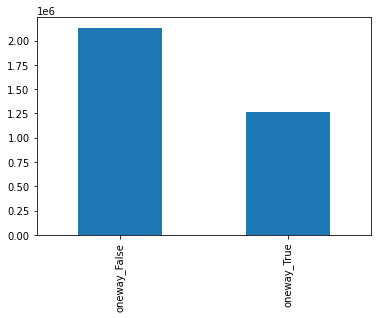

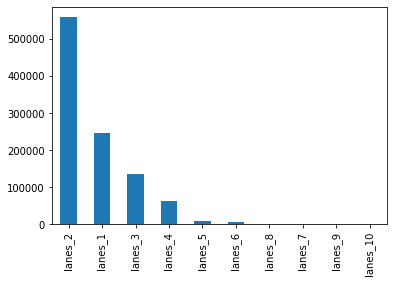

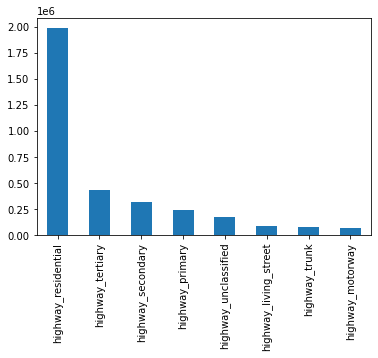

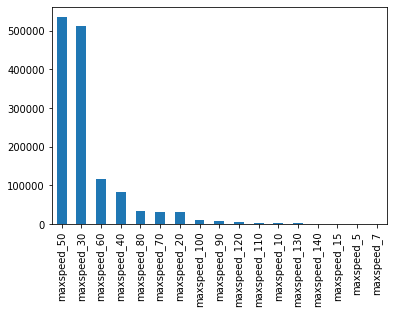

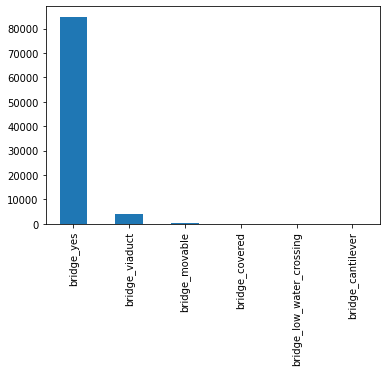

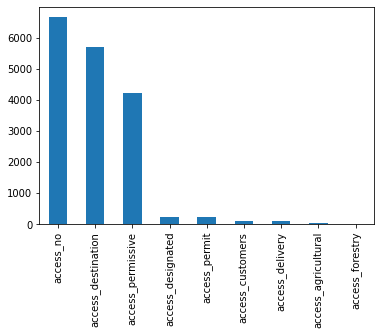

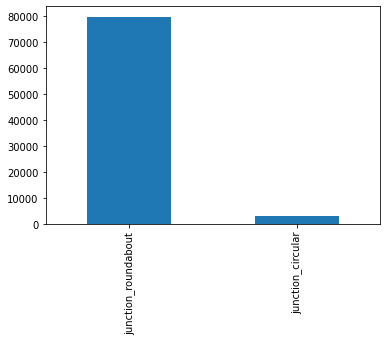

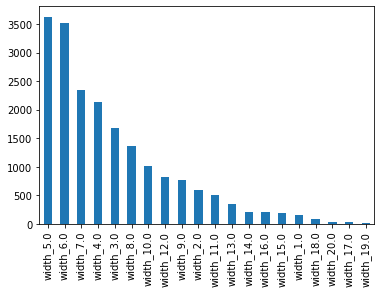

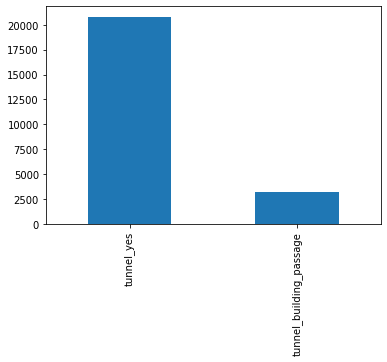

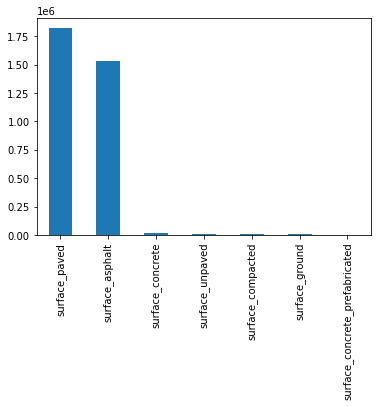

In [11]:
for f in features:
    data[f].value_counts().plot(kind="bar")
    plt.show()

<AxesSubplot:>

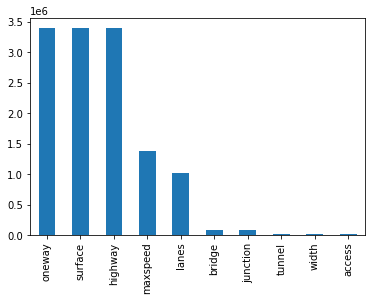

In [12]:
data.notna().sum().sort_values(ascending=False).plot(kind="bar")

In [13]:
features_numeric = ["lanes", "maxspeed", "width"]

for feature in features_numeric:
    data[feature] = data[feature].apply(lambda x: float(x.split("_")[1]) if x is not None else None).astype(float)

In [14]:
# data = data[["oneway", "lanes", "highway", "maxspeed"]]

In [15]:
# target_columns = [c for c in data.columns if 'highway' in c]
target_column = 'highway'
data = data[data[target_column].notnull()]

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X = data.drop(columns=[target_column])
Y = data[target_column]
y = le.fit_transform(Y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, shuffle=True, stratify=y)
display(X_train)
display(y_train)

oneway  \
continent     country              city         h3_id                           
Europe        Serbia               Belgrade     891e1b29c0bffff  oneway_False   
              France               Bordeaux     89186b6c88bffff  oneway_False   
              Finland              Helsinki     8908996d26fffff  oneway_False   
              Austria              Vienna       891e15b5027ffff   oneway_True   
North America United States        Philadelphia 892a134f64bffff  oneway_False   
...                                                                       ...   
Europe        Italy                Milan        891f99ccdc7ffff  oneway_False   
Asia          United Arab Emirates Abu Dhabi    8943a027447ffff   oneway_True   
Oceania       Australia            Sydney       89be0e34e4bffff  oneway_False   
Asia          Turkey               Istanbul     891ec9b8417ffff  oneway_False   
Europe        Norway               Oslo         890999385a7ffff  oneway_False   

                                                                 lanes  \
continent     country              city         h3_id                    
Europe        Serbia               Belgrade     891e1b29c0bffff    NaN   
              France               Bordeaux     89186b6c88bffff    NaN   
              Finland              Helsinki     8908996d26fffff    NaN   
              Austria              Vienna       891e15b5027ffff    NaN   
North America United States        Philadelphia 892a134f64bffff    NaN   
...                                                                ...   
Europe        Italy                Milan        891f99ccdc7ffff    NaN   
Asia          United Arab Emirates Abu Dhabi    8943a027447ffff    NaN   
Oceania       Australia            Sydney       89be0e34e4bffff    NaN   
Asia          Turkey               Istanbul     891ec9b8417ffff    NaN   
Europe        Norway               Oslo         890999385a7ffff    NaN   

                                                                 maxspeed  \
continent     country              city         h3_id                       
Europe        Serbia               Belgrade     891e1b29c0bffff       NaN   
              France               Bordeaux     89186b6c88bffff      30.0   
              Finland              Helsinki     8908996d26fffff      30.0   
              Austria              Vienna       891e15b5027ffff       NaN   
North America United States        Philadelphia 892a134f64bffff       NaN   
...                                                                   ...   
Europe        Italy                Milan        891f99ccdc7ffff       NaN   
Asia          United Arab Emirates Abu Dhabi    8943a027447ffff       NaN   
Oceania       Australia            Sydney       89be0e34e4bffff       NaN   
Asia          Turkey               Istanbul     891ec9b8417ffff       NaN   
Europe        Norway               Oslo         890999385a7ffff      50.0   

                                                                bridge access  \
continent     country              city         h3_id                           
Europe        Serbia               Belgrade     891e1b29c0bffff    NaN    NaN   
              France               Bordeaux     89186b6c88bffff    NaN    NaN   
              Finland              Helsinki     8908996d26fffff    NaN    NaN   
              Austria              Vienna       891e15b5027ffff    NaN    NaN   
North America United States        Philadelphia 892a134f64bffff    NaN    NaN   
...                                                                ...    ...   
Europe        Italy                Milan        891f99ccdc7ffff    NaN    NaN   
Asia          United Arab Emirates Abu Dhabi    8943a027447ffff    NaN    NaN   
Oceania       Australia            Sydney       89be0e34e4bffff    NaN    NaN   
Asia          Turkey               Istanbul     891ec9b8417ffff    NaN    NaN   
Europe        Norway               Oslo         890999385a7ffff    NaN    NaN   

array([3, 4, 3, ..., 3, 5, 7])

In [16]:
xgb_classifier = xgb.XGBClassifier(objective="multi:softmax", 
    random_state=random_seed, 
    n_jobs=-1, 
    use_label_encoder=False, 
    num_class=len(le.classes_), 
    n_estimators=1000, 
    tree_method="gpu_hist", 
    max_depth=10,
    eval_metric="mlogloss",
    enable_categorical=True)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=True,
              eval_metric='mlogloss', gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              num_class=8, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='gpu_hist',
              use_label_encoder=False, ...)

In [17]:
proba = xgb_classifier.predict_proba(X_test)
y_pred = xgb_classifier.predict(X_test)

In [18]:
from sklearn.metrics import f1_score, classification_report

print("F1 Score", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=le.classes_))

F1 Score 0.3308718039479084
                       precision    recall  f1-score   support

highway_living_street       0.64      0.14      0.23     17270
     highway_motorway       0.60      0.50      0.54     14481
      highway_primary       0.43      0.30      0.36     48428
  highway_residential       0.70      0.97      0.81    397555
    highway_secondary       0.35      0.23      0.28     64685
     highway_tertiary       0.33      0.10      0.15     86446
        highway_trunk       0.43      0.19      0.26     15359
 highway_unclassified       0.36      0.01      0.02     34859

             accuracy                           0.64    679083
            macro avg       0.48      0.30      0.33    679083
         weighted avg       0.57      0.64      0.57    679083



In [19]:
from eli5.sklearn import PermutationImportance
import eli5
# pi = PermutationImportance(xgb_classifier).fit(X_test, y_test)
eli5.show_weights(xgb_classifier)

Weight,Feature
0.3049,lanes
0.2576,oneway
0.2337,maxspeed
0.0593,bridge
0.0515,junction
0.0350,surface
0.0243,tunnel
0.0206,access
0.0131,width


In [20]:
# from tpot import TPOTClassifier
# pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
#                                     random_state=42, verbosity=2, config_dict='TPOT light')
# pipeline_optimizer.fit(X_train, y_train)
# print(pipeline_optimizer.score(X_test, y_test))